Functions
============


Function objects are constructed in python to interface with objects such as the finite element matrices in the C layer, which is more efficient. They provide a high level interface for users to compose model behaviour (such as viscosity), as well as a natural interface by which discrete data (such as finite element variables) may be utilised. Functions must be used by various objects in Underworld, e.g. systems, integrals, gLucifer plotting - if they are not used an exception will be thrown and the code will stop.

Functions aim to achieve a number of goals:
* Provide a natural interface to construct equations and analysis tools within python.
* Allow discrete objects to be used in combination with continuous objects.
* Handle the evaluation of discrete objects in the most efficient manner.
* All evaluations occur at the C level for efficiency.

Functions allow users to solve many problems in geodynamics, for example where the properties of a specific material are a function of temperature (for example). An example of a more complex relationship is where the viscosity is a function of temperature, both of which are be required by Underworld to solve the system.

In some cases such relationships are further complicated in that material properties can be assigned to swarm particles, while the temperature data exists on finite element (FE) variables associated with the mesh. As swarm particles are free to move around the mesh, while FE variables are fixed on the mesh. In this case functions provide a way for information to be passed between swarms and FE variables.

In this notebook we will examine a few examples of using functions in underworld. This is a continuation of the swarm particle and FE variable notebooks, so there is a certain amount of assumed knowledge about swarms and FE variables.

**This notebook is broken down into the following examples:**

1. input function and function evaluation
2. using functions to relate FE variables and swarm objects
3. using functions as inputs
4. revisit making shapes with swarm particles, this time using functions
5. limitations of using Underworld functions

**Keywords:** functions, swarms, FE variables, materials


In [1]:
import underworld as uw
from underworld import function as fn
import numpy as np
import glucifer
import math

The input function and function evaluation in Underworld
----

The **input function**, ``fn.input()``, outputs whatever was input into the function. 

In [2]:
y = fn.input()

**Evaluating** a function takes the input in brackets and outputs a numpy array. Using the above function as an example the output will be whatever was input.

In [3]:
print( y.evaluate( 1.0 ) )
print( y.evaluate( (1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0) ) )

[[ 1.]]
[[ 1.  2.  3.  4.  5.  6.  7.  8.]]


The evaluate function outputs a numpy array of double precession floating point values. To get a single floating point value the array element must be directly pointed to by adding ``[0][0]`` after ``evaluate()``. For example,

In [4]:
print( y.evaluate(1.0),       type(y.evaluate(1.0)) )
print( y.evaluate(2.0)[0],    type(y.evaluate(2.0)[0]) )
print( y.evaluate(3.0)[0][0], type(y.evaluate(3.0)[0][0]) )

(array([[ 1.]]), <type 'numpy.ndarray'>)
(array([ 2.]), <type 'numpy.ndarray'>)
(3.0, <type 'numpy.float64'>)


**More complex functions** can be built up and evaluated as needed using Underworld. The Underworld functions are broadly broken down into the following:

1. **fn.misc**: `constant`, `min`, `max`
2. **fn.math**: basic maths functions such as `exp`, `sin`, `pow`, `sqrt`
3. **fn.branching**: used for `if` statement type operations
4. **fn.expection.SafeMaths**: checks if divide by zero, invalid domain or value under/overflow are encountered during the evaluation of its subject function.
5. **fn.input/fn.coord**: useful when we want to construct a function which operates on only a particular coordinate, such as a depth dependent density
6. information on other functions can be accessed by ``help()``

**For a more complete list of available functions use ``Tab`` complete after typing ``fn.`` in a notebook cell.**

**Using coordinates as ``fn.input``**

In Underworld we typically need to pass the spatial coordinates to functions defining the rheology of our physical system setup. In these cases ``fn.input`` is in the form of a python tuple containing the spatial coordinates, in 3D $(x, y, z)$.

Since the function input is used so frequently to provide the spatial coordinates to functions in Underworld the alias ``fn.coord()`` defined to be identical to ``fn.input``. This makes the code more intuitive as ``fn.coord()[i]`` where $i=0, 1, 2$ will give the x, y, or z coordinate in 3D.

In the example below the function $func = \max \left( 1, x^2 \right)$ is defined and takes its input from the Underworld function ``fn.input()``. This example uses the first element of the coordinate tuple, i.e. the $x$ value only, and shows how some basic functions are used in Underworld.

In [5]:
func = fn.math.pow( fn.coord()[0], 2.0 )
func = fn.misc.max( func, 1.0 )

In [6]:
print( func.evaluate( 0.0 ) )
print( func.evaluate( (4.0, 1.0) ) )

[[ 1.]]
[[ 16.]]


Notes:

1. python floats are automatically convereted into ``fn.constant`` when a function is used
2. failing to use Underworld functions (e.g. using ``math.sin`` instead of ``fn.sin``) will cause an exception when the function is used to create a system (e.g. Stokes system)
3. ``math`` or ``numpy`` functions are fine when they are used outside of Underworld systems, e.g. allocating swarm variable values

Using functions to relate FE variables
----------

In this section we go through an example of using functions to setup relationships between FE variables, specifically making the viscosity and density of the fluid dependent on the temperature.

Create a mesh and temperature field

In [7]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (64, 64), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.))

temperatureField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )

Set some initial conditions for the temperature

In [8]:
for index, coord in enumerate(mesh.data):
    temperatureField.data[index] = (1.0 - coord[1]*coord[1])

Plot the temperature field


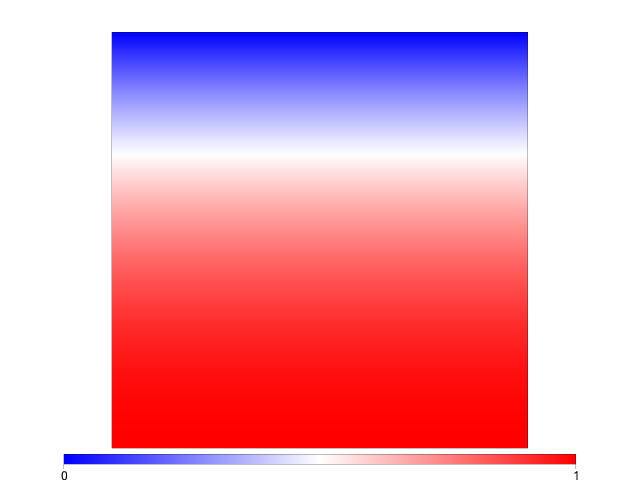

In [9]:
fig = glucifer.Figure()
fig.append( glucifer.objects.Surface( mesh, temperatureField, colours = 'blue white red' ) )
fig.show()

**Evaluate function**

We can use the ``evaluate`` function on finite element variables to get values off the mesh points. The evaluate function in this case interpolates between the known values on the node points.

In [10]:
print('Temperature at z=0.5 is {0:.3f}'.format(temperatureField.evaluate((0.5, 0.5))[0][0]))

Temperature at z=0.5 is 0.750


Using functions as inputs
----

Previous user guides have already used functions as inputs for constructing and evaluating various objects. e.g. using the mesh as input when creating a finite element variable. Functions are also used as inputs into other functions. For example using the temperature field as input to equations governing the system rheology.


**Define a viscosity function**

Here we can use functions to construct a viscosity function that is true for all spatial coordinates as well as for all time. The underworld functions, denoted by ``fn``, allow us to write relationships intuitively without needing to re-write them each time a point needs to be evaluated.

The hard work of evaluating the function when it is needed is done by the underworld system solvers (see the **Systems** user guide).

Here we choose:

$$
    \eta = A \exp \left( - 10 T \right)
$$

where $A = 1$ and $T$ is the temperature field defined previously at each mesh point.

In [11]:
viscosityFn = fn.misc.constant(1.0) * fn.math.exp( -10.0 * temperatureField )

To demonstrate that this function works correctly when it is needed we will plot the viscosity function as a function of ``x`` and ``z``.


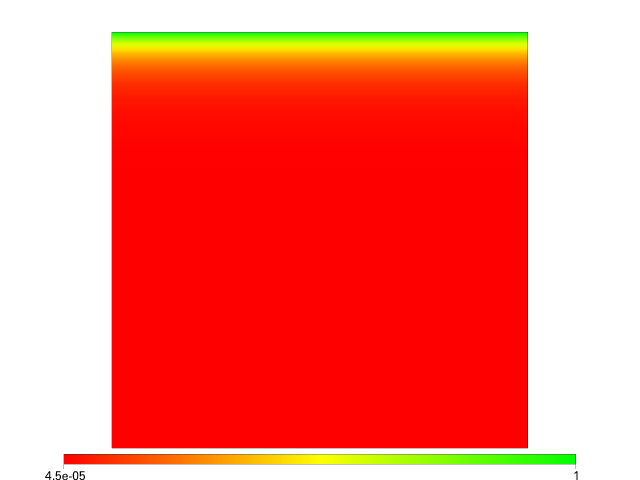

In [12]:
figEta = glucifer.Figure()
figEta.append( glucifer.objects.Surface( mesh, viscosityFn, colours = 'red yellow green' ) )
figEta.show()

**Define a density function**

Now we will define a simple density function to be
$$
    \rho = Ra T
$$
where $Ra$ is the Rayleigh number.

In [13]:
Ra = 1.0e6  # Rayleigh number

densityFn = Ra*temperatureField

Now plot the resulting density function.


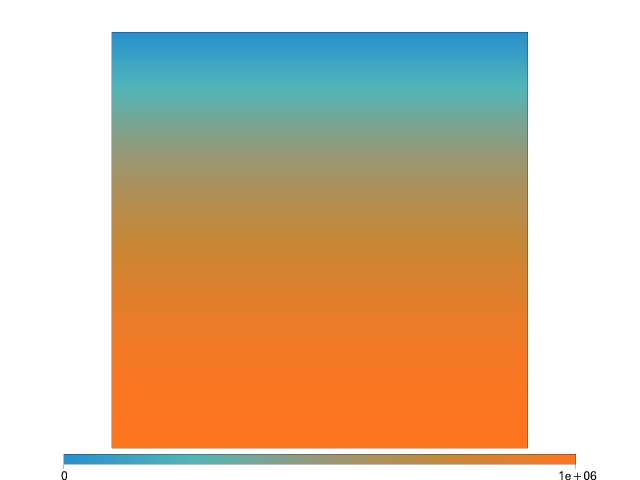

In [14]:
figRho = glucifer.Figure()
figRho.append( glucifer.objects.Surface(mesh, densityFn) )
figRho.show()

Making shapes using conditional functions
-----

In this example we will make a few different shapes using a single particle swarm, but by changing the ``swarmVariable``. By using an additional variable for each particle any information can be carried by the particles, for example densities and viscosities. These can then be evaluated on the mesh points, allowing interaction between the swarms and the FE variables - i.e. allowing the temperature field to be coupled to viscosity.

For more information on how this method can be used to set material parameters to particles see the example **1_05_StokesSinker**.

**Create a higher resolution mesh**

In [15]:
res = 64
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.) )

**Create a swarm with random positions on the mesh**

In [16]:
# initialise a swarm. Note this must be the whole mesh, i.e. elementMesh.
swarm = uw.swarm.Swarm( mesh=mesh )
# add a data variable which will store an index to determine material
swarmIndex = swarm.add_variable( dataType="int", count=1 )
# create a layout object that will populate the swarm across the whole domain
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
# activate the layout object
swarm.populate_using_layout( layout=swarmLayout )

**Define a shape: circle**

Want to have a definition of a circle based on the position of each swarm particle.

Firstly, create a function that returns true if the coordinates are inside a given function. To do this we define a python function that mathematically describes a shape, in this case a circle offset to the centre of the sinker. Note that this returns an underworld function, which can be used in the branching condition function below.




In [17]:
def circleFnGenerator(centre, radius):
    coord = fn.coord()
    offsetFn = coord - centre
    return fn.math.dot( offsetFn, offsetFn ) < radius**2

Specify parameters for the circle

In [18]:
sphereRadius = 0.1
sphereCentre = (0.5, 0.5)

**Set index for each swarm particle**

Use the location of each particle to set the index depending on the position, stored in the 2 dimensional vector called ``coord``. In this case the circle function defined above will return ``True`` when the ``coord`` is within the shape and ``False`` otherwise. The branching conditional function will then set the ``swarmIndex`` data value for that particle to equal the ``1`` if it is inside the circle, or the ``0`` otherwise.

**Note:** ``fn.coord()`` in this context contains the swarm particle coordinates when the function is evaluated (e.g. in plotting or in the system solver).

In [19]:
# create a circle
coord = fn.coord()
# set up the condition for being in a circle. if not in sphere then will return 0
conditions = [ ( circleFnGenerator( sphereCentre, sphereRadius) , 1), 
               ( True                                           , 0) ]
# use the branching conditional function to set each particle's index
swarmIndex.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)

**Branching conditional function**

The swarm index is set using a underworld function called 'branching.conditional' which has the form of:

    if( [ (condition function 1, action function 1), 
          (condition function 2, action function 2), 
          ... 
          (True                , final action function), 
          ] )

which begins at the first function and if it is true it preforms the first action, if it is not true then the next conditional function is tested and so on. If no condition functions return true then the function will return an error. To avoid this error the last condition function is set to true and the final action function serves the purpose of ``everything else``, for example a default background swarm index as in this case.


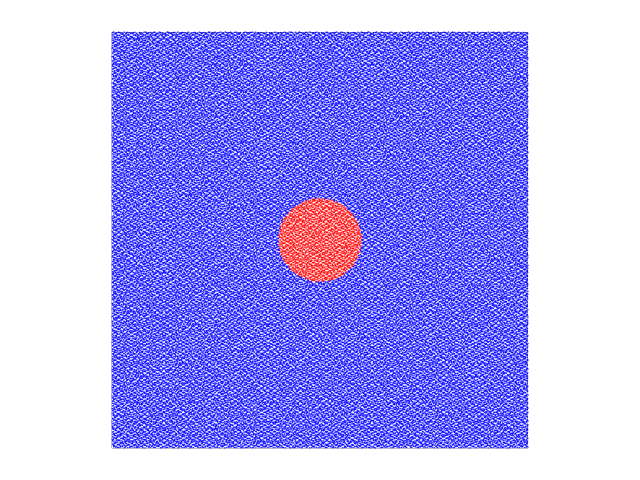

In [20]:
fig = glucifer.Figure()
fig.append( glucifer.objects.Points( swarm=swarm, fn_colour=swarmIndex, colours='blue red', 
                               colourBar = False, pointSize=2.0 ) )
fig.show()

**Define a shape: Box**

We use the same method as above to define a box and use this to set the particle swarm index.

In [21]:
def squareFnGenerator(centre = (0.0,0.0), width = 1.0):
    coord = fn.coord()
    xDist = coord[0] - centre[0]
    zDist = coord[1] - centre[1]
    edgeDist = width*width/4.0
    xCond = (xDist*xDist) < edgeDist
    zCond = (zDist*zDist) < edgeDist
    cond =  (xCond & zCond)
    return cond

In [22]:
squareCentre = (0.5, 0.5)
squareWidth  = 0.1

In [23]:
# create a square
coord = fn.coord()
# set up the condition for being in a circle. if not in sphere then will return 0
conditions = [ ( squareFnGenerator( squareCentre, squareWidth ) , 1 ), 
               ( True                                           , 0 ) ]
# use the branching conditional function to set each particle's index
swarmIndex.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)


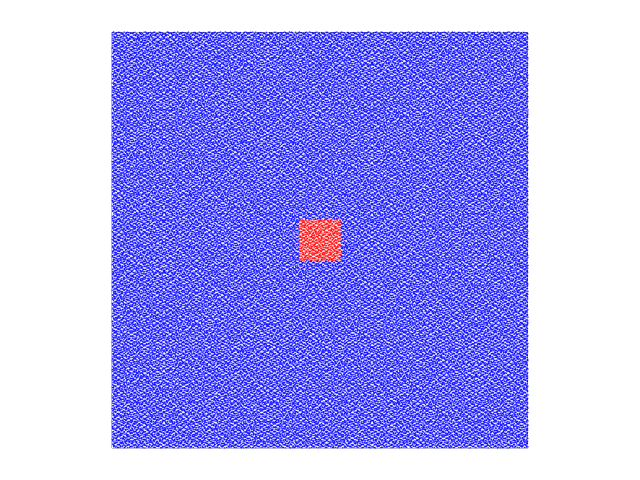

In [24]:
fig = glucifer.Figure()
fig.append( glucifer.objects.Points( swarm=swarm, fn_colour=swarmIndex, colours='blue red', 
                               colourBar = False, pointSize=2.0 ) )
fig.show()

Limitations of Underworld functions
-----

Underworld functions are evaluated in the C layer of the code, so they can be used on the data structures themselves and they are very computationally efficient. However they do have limitations regarding the types of input they can parse.

**Integer and float inputs**

While Underworld functions accept floating point numbers as input, they often throw exceptions when integers are used in functions or in their input.

In [25]:
func1 = fn.misc.max( fn.input(), 1. )
func2 = fn.misc.max( fn.input(), 1  )  # same as func1 but using an integer

The below code tests these functions in four combinations to show where errors are encountered.

In [26]:
print('\nInput: float; func1')
try:
    x = func1.evaluate(4.)
    print('   out = {0:}'.format(x))
except Exception, e:
    print('Error reported: \n'+str(e))

print('\nInput: float; func2')
try:
    x = func2.evaluate(4.)
    print('   out = {0:}'.format(x))
except Exception, e:
    print('Error reported: \n'+str(e))

print('\nInput: int; func1')
try:
    x = func1.evaluate(4)
    print('   out = {0:}'.format(x))
except Exception, e:
    print('Error reported: \n'+str(e))

print('\nInput: int; func2')
try:
    x = func2.evaluate(4)
    print('   out = {0:}'.format(x))
except Exception, e:
    print('Error reported: \n'+str(e))


Input: float; func1
   out = [[ 4.]]

Input: float; func2
Error reported: 
Operand in binary function does not appear to return a 'double' type value, as required.

Input: int; func1
Error reported: 
Input provided for function evaluation does not appear to be supported.

Input: int; func2
Error reported: 
Input provided for function evaluation does not appear to be supported.


**Limitations using functions as input to functions**

As a demonstration of potential errors when using different input Underworld functions and objects the following testing function is defined based on the branching function used to define shapes above.

In [27]:
def testObject( inputObject ):
    print('Type = ',type(inputObject))
    try:
        swarmIndex.data[:] = fn.branching.conditional( conditions ).evaluate( inputObject )
    except Exception, e:
        print('Error reported: \n'+ str(e))
    else:
        print('No error')

Now we can test few common Underworld objects as input into the branching function relating to the swarm variable ``swarmIndex``.

In [28]:
print('Test "swarm"')
testObject(swarm)
print('\nTest "swarm.particleCoordinates.data"')
testObject(swarm.particleCoordinates.data)
print('\nTest "swarm.particleCoordinates"')
testObject(swarm.particleCoordinates)

Test "swarm"
('Type = ', <class 'underworld.swarm._swarm.Swarm'>)
No error

Test "swarm.particleCoordinates.data"
('Type = ', <type 'numpy.ndarray'>)
No error

Test "swarm.particleCoordinates"
('Type = ', <class 'underworld.swarm._swarmvariable.SwarmVariable'>)
Error reported: 
Input provided for function evaluation does not appear to be supported.


In the above examples the ``swarm`` and ``swarm.particleCoordinates.data`` objects were successfully used as input, while the ``swarm.particleCoordinates`` object was not. For the first two of these Underworld was able to determine that the swarm particle coordinate data, consisting of sets of $(x, y, z)$ numbers, was asked for. This was not true of the 3rd case as Underworld stores this object as a swarm variable, which is the same structure used for any information carried by the swarm, so it is ambiguous.

In the following cells a variety of different objects are passed into the testing function to see the range of error messages.

In [29]:
print('Test "mesh.data"')
testObject(mesh.data)

Test "mesh.data"
('Type = ', <type 'numpy.ndarray'>)
Error reported: 
could not broadcast input array from shape (4225,1) into shape (81920,1)


While the ``mesh.data`` does contain sets of coordinates (of the node points) it does not contain the same number as the number of swarm particles. So the length (shape) of the object is wrong.

In [30]:
print('Test "temperatureField"')
testObject(temperatureField)

Test "temperatureField"
('Type = ', <class 'underworld.mesh._meshvariable.MeshVariable'>)
Error reported: 
Input provided for function evaluation does not appear to be supported.


In this case Underworld does not understand what the user is trying to do.

In [31]:
print('Test "temperatureField.data"')
testObject(temperatureField.data)

Test "temperatureField.data"
('Type = ', <type 'numpy.ndarray'>)
Error reported: 
Trying to extract component 1 from from object with size 1.
Index must be in [0,0].


The temperature data contains a single temperature value at each mesh node. So when this is used as input where Underworld is expecting coordinate data (sets of 2 or 3 values) then an error is reported that there are not enough components.

**Take home message**

You have to think about what you are doing. Underworld functions can sometimes guess what you are trying to do, but not always.